##### Copyright 2023 The MediaPipe Authors. All Rights Reserved.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Face Landmarks Detection with MediaPipe Tasks

This notebook shows you how to use MediaPipe Tasks Python API to detect face landmarks from images.

## Preparation

Let's start with installing MediaPipe.

In [1]:
!pip install -q mediapipe

^C



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Then download the off-the-shelf model bundle(s). Check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/face_landmarker#models) for more information about these model bundles.

In [2]:
!wget -O face_landmarker_v2_with_blendshapes.task -q https://storage.googleapis.com/mediapipe-models/face_landmarker/face_landmarker/float16/1/face_landmarker.task

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
!curl -o face_landmarker_v2_with_blendshapes.task -s https://storage.googleapis.com/mediapipe-models/face_landmarker/face_landmarker/float16/1/face_landmarker.task

## Visualization utilities

In [4]:
#@markdown We implemented some functions to visualize the face landmark detection results. <br/> Run the following cell to activate the functions.

from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
import matplotlib.pyplot as plt


def draw_landmarks_on_image(rgb_image, detection_result):
  face_landmarks_list = detection_result.face_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected faces to visualize.
  for idx in range(len(face_landmarks_list)):
    face_landmarks = face_landmarks_list[idx]

    # Draw the face landmarks.
    face_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    face_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in face_landmarks
    ])

    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_tesselation_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_contours_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_IRISES,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp.solutions.drawing_styles
          .get_default_face_mesh_iris_connections_style())

  return annotated_image

def plot_face_blendshapes_bar_graph(face_blendshapes):
  # Extract the face blendshapes category names and scores.
  face_blendshapes_names = [face_blendshapes_category.category_name for face_blendshapes_category in face_blendshapes]
  face_blendshapes_scores = [face_blendshapes_category.score for face_blendshapes_category in face_blendshapes]
  # The blendshapes are ordered in decreasing score value.
  face_blendshapes_ranks = range(len(face_blendshapes_names))

  fig, ax = plt.subplots(figsize=(12, 12))
  bar = ax.barh(face_blendshapes_ranks, face_blendshapes_scores, label=[str(x) for x in face_blendshapes_ranks])
  ax.set_yticks(face_blendshapes_ranks, face_blendshapes_names)
  ax.invert_yaxis()

  # Label each bar with values
  for score, patch in zip(face_blendshapes_scores, bar.patches):
    plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{score:.4f}", va="top")

  ax.set_xlabel('Score')
  ax.set_title("Face Blendshapes")
  plt.tight_layout()
  plt.show()

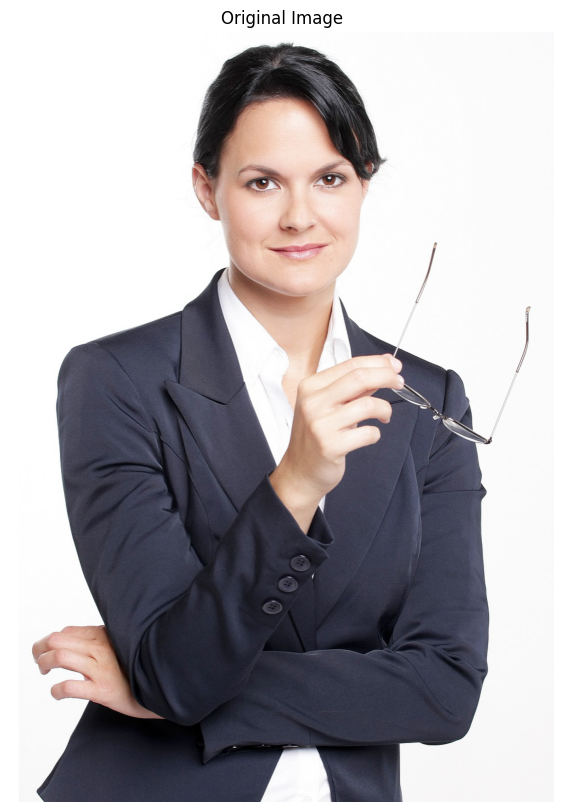

c:\Users\875745\Downloads\face-fortune-python\env\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


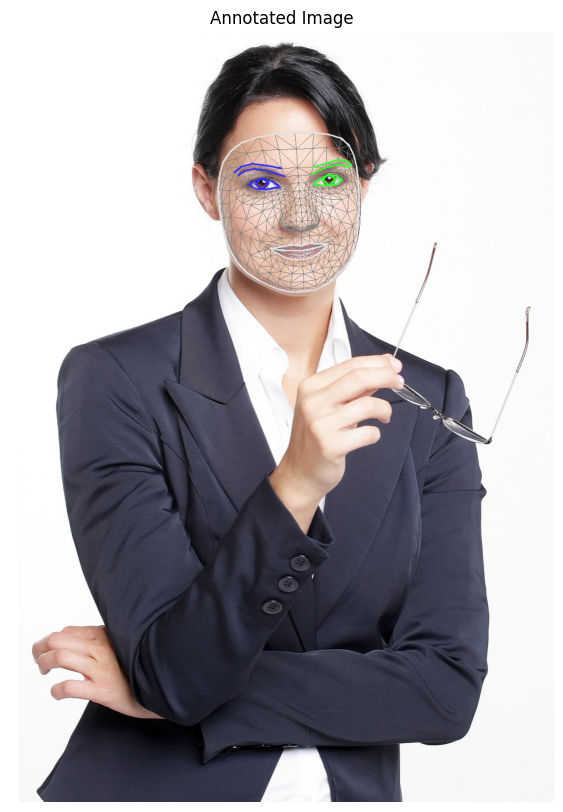

In [16]:
import cv2
import matplotlib.pyplot as plt
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import requests
from io import BytesIO

# Function to download and read image
def download_image(url):
    response = requests.get(url)
    return cv2.imdecode(np.frombuffer(response.content, np.uint8), cv2.IMREAD_COLOR)

# Download the image
img_url = "https://storage.googleapis.com/mediapipe-assets/business-person.png"
img = download_image(img_url)

# Display the original image
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Original Image')
plt.show()

# STEP 2: Create an FaceLandmarker object.
base_options = python.BaseOptions(model_asset_path='face_landmarker_v2_with_blendshapes.task')
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)
detector = vision.FaceLandmarker.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image(image_format=mp.ImageFormat.SRGB, data=cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# STEP 4: Detect face landmarks from the input image.
detection_result = detector.detect(image)

# STEP 5: Process the detection result. In this case, visualize it.
def draw_landmarks_on_image(rgb_image, detection_result):
    face_landmarks_list = detection_result.face_landmarks
    annotated_image = np.copy(rgb_image)

    # Loop through the detected faces to visualize.
    for idx in range(len(face_landmarks_list)):
        face_landmarks = face_landmarks_list[idx]

        # Draw the face landmarks.
        face_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
        face_landmarks_proto.landmark.extend([
            landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in face_landmarks
        ])

        solutions.drawing_utils.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks_proto,
            connections=mp.solutions.face_mesh.FACEMESH_TESSELATION,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp.solutions.drawing_styles
            .get_default_face_mesh_tesselation_style())
        solutions.drawing_utils.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks_proto,
            connections=mp.solutions.face_mesh.FACEMESH_CONTOURS,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp.solutions.drawing_styles
            .get_default_face_mesh_contours_style())
        solutions.drawing_utils.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks_proto,
            connections=mp.solutions.face_mesh.FACEMESH_IRISES,
              landmark_drawing_spec=None,
              connection_drawing_spec=mp.solutions.drawing_styles
              .get_default_face_mesh_iris_connections_style())

    return annotated_image

annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)

# Display the annotated image using Matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(annotated_image)
plt.axis('off')
plt.title('Annotated Image')
plt.show()

We will also visualize the face blendshapes categories using a bar graph.

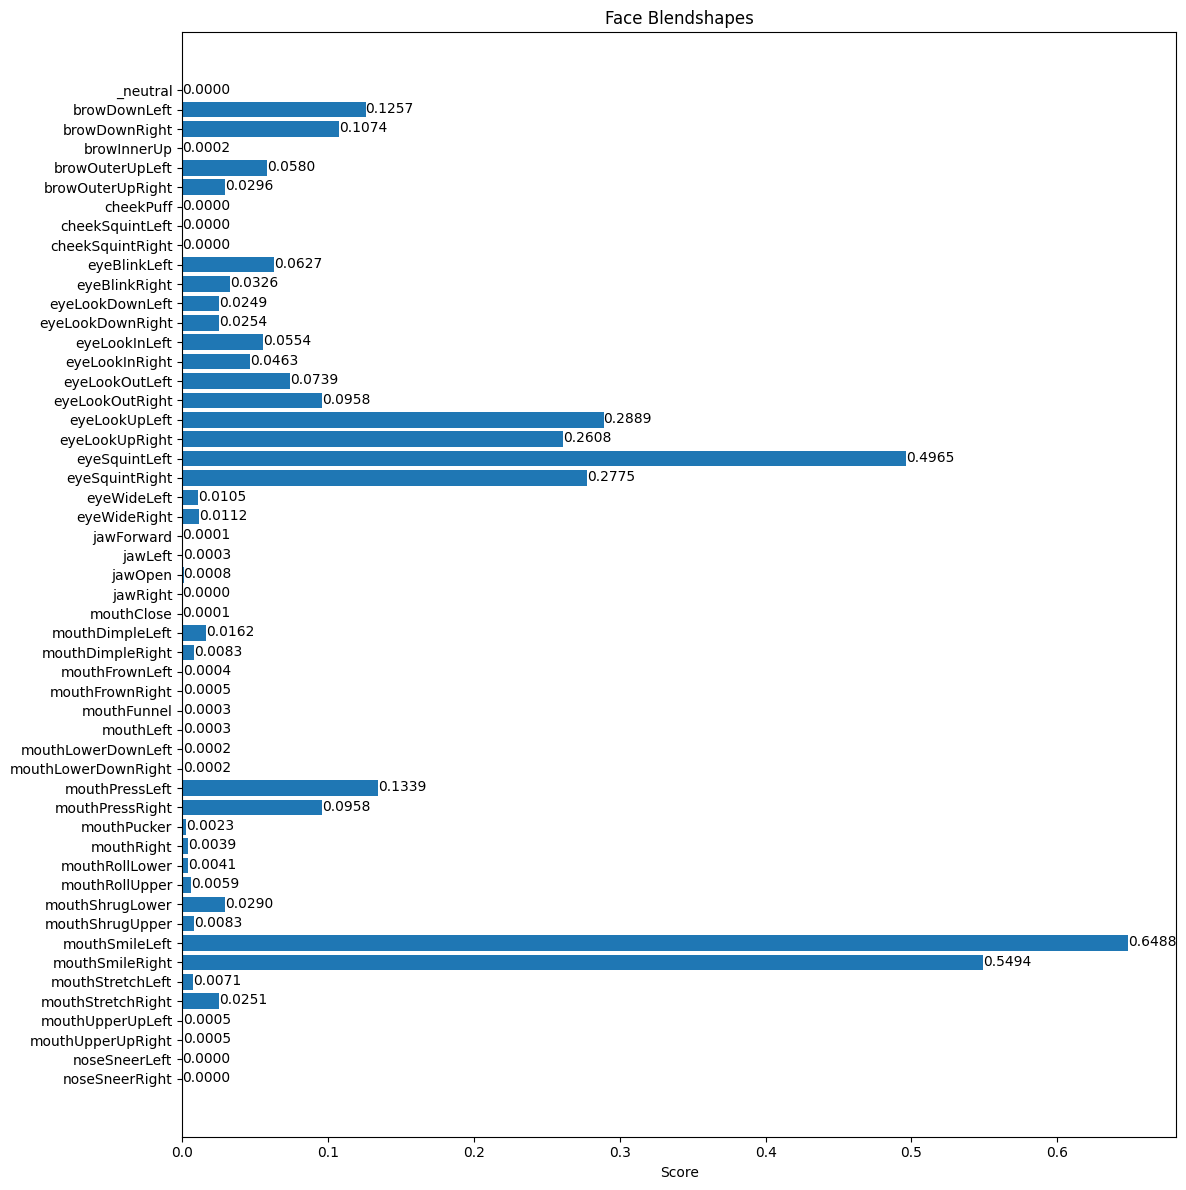

In [12]:
plot_face_blendshapes_bar_graph(detection_result.face_blendshapes[0])

In [17]:
# Function to print face blendshapes as raw text
def print_face_blendshapes(detection_result):
    face_blendshapes = detection_result.face_blendshapes[0]
    for blendshape in face_blendshapes:
        print(f"{blendshape.category_name}: {blendshape.score}")

# Call the function with the detection result
print_face_blendshapes(detection_result)

_neutral: 2.7253420284978347e-06
browDownLeft: 0.12565556168556213
browDownRight: 0.1074170395731926
browInnerUp: 0.00015090921078808606
browOuterUpLeft: 0.058031488209962845
browOuterUpRight: 0.029591210186481476
cheekPuff: 3.763052154681645e-05
cheekSquintLeft: 2.0550157842080807e-07
cheekSquintRight: 2.67368733375406e-07
eyeBlinkLeft: 0.06272827088832855
eyeBlinkRight: 0.032636839896440506
eyeLookDownLeft: 0.024934258311986923
eyeLookDownRight: 0.02537202648818493
eyeLookInLeft: 0.05538533255457878
eyeLookInRight: 0.04630367085337639
eyeLookOutLeft: 0.07394014298915863
eyeLookOutRight: 0.09583929926156998
eyeLookUpLeft: 0.2888629138469696
eyeLookUpRight: 0.2607918083667755
eyeSquintLeft: 0.49653345346450806
eyeSquintRight: 0.27751168608665466
eyeWideLeft: 0.010500243864953518
eyeWideRight: 0.011249938979744911
jawForward: 9.395218512509018e-05
jawLeft: 0.0003268203872721642
jawOpen: 0.0007976042688824236
jawRight: 1.8485996406525373e-05
mouthClose: 0.0001070260550477542
mouthDimpleL

And print the transformation matrix.

In [13]:
print(detection_result.facial_transformation_matrixes)

[array([[ 9.92205501e-01, -6.04903474e-02,  1.08946197e-01,
         1.18711746e+00],
       [ 9.10740122e-02,  9.48733926e-01, -3.02671373e-01,
         2.23701134e+01],
       [-8.50522369e-02,  3.10234487e-01,  9.46847558e-01,
        -6.80049210e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])]
